## Comparison of different cases of DGM inversion with linear forward operator

In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
workdir='/home/jorge/Git_projs/VAE_SGD/'
os.chdir(workdir)
# Load from module
from SGD_DGM import SGDsetup,SGD_ninits,SGD_DGM

### Load truth model:

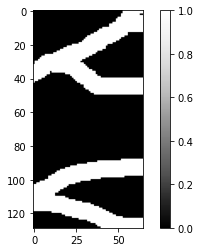

In [3]:
suffix = 'mc2'
ncase = 'no noise' # 'no noise' or 'noise'
mload = Path('test_models/{0}.npy'.format(suffix))
x_true = np.load(mload)
x_true = x_true.reshape(1,1,129,65)

# plot subsurface model
fig, ax = plt.subplots()
clb = ax.imshow(x_true[0,0,:,:], cmap='Greys_r')
fig.colorbar(clb)

# Simulate from true training channels

model_true = np.copy(x_true)
#model_true[model_true < 0.5] = 0
#model_true[model_true >= 0.5] = 1
#model_true[model_true==0]=0.08 # m/ns
#model_true[model_true==1]=0.06 # m/ns
model_true = 0.06 + 0.02*(1-model_true)
model_true=1/model_true

### Then, generate synthetic data:

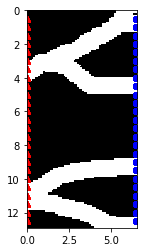

In [4]:
# Simulate from true training channels

os.chdir('SGAN')
from tomokernel_straight import tomokernel_straight_2D
os.chdir(workdir)
nx=65 # Here x is the horizontal axis (number of columns) and not the number of rows
ny = 129 # Here y is the vertical axis (number of rows) and not the number of columns

# The x-axis is varying the fastest 
x = np.arange(0,(nx/10)+0.1,0.1)                      
y = np.arange(0,(ny/10)+0.1,0.1) 
sourcex = 0.01
spacing = 0.5
sourcez = np.arange(spacing,ny/10,spacing)                         
receiverx = nx/10-0.01
receiverz = np.arange(spacing,ny/10,spacing)   
nsource = len(sourcez); nreceiver = len(receiverz)
ndata=nsource*nreceiver
data=np.zeros((ndata,4))
# Calculate acquisition geometry (multiple-offset gather)
for jj in range(0,nsource):
    for ii in range(0,nreceiver):
        data[ ( jj ) * nreceiver + ii , :] = np.array([sourcex, sourcez[jj], receiverx, receiverz[ii]])

# Calculate forward modeling kernel (from Matlab code by Dr. James Irving, UNIL)
A = tomokernel_straight_2D(data,x,y) # Distance of ray-segment in each cell for each ray
A=np.array(A.todense())

sim_true=A@model_true.flatten()

# plot subsurface model with sources and receivers
fig, ax = plt.subplots()
ax.pcolormesh(x,y,model_true[0,0,:,:], cmap='Greys_r')
ax.plot(data[:,0],data[:,1], 'r^') # sources
ax.plot(data[:,2], data[:,3], 'bo') # receivers
ax.invert_yaxis()
ax.set_aspect('equal','box')

In [5]:
# noise cases:
if ncase == 'noise':
    # add synthetic noise
    noise_lvl = 0.25
    #nnoise = noise_lvl*np.random.randn(len(sim_true))
    nnoise = np.load('noiserealz.npy') # ns
    sim_true = sim_true + noise_lvl*nnoise # noise_lvl scales the noise.
    print(noise_lvl*nnoise[:10]) # ns
    noisestr = '_noise'
elif ncase == 'no noise':
    noisestr = ''
    
print(sim_true[:10]) # ns

[ 87.20833333  89.55708196  89.12601286  89.95910883  91.09316376
  92.17834269  94.76929608  96.85659095 104.34586758 110.9934262 ]


### Load trained DGM (VAE or SGAN):

In [6]:
DGM = 'VAE' # choose from: 'VAE' or 'SGAN'

In [7]:
# check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
#cuda = False

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
if str(device) == 'cuda':
    cuda=True
else:
    cuda=False

if DGM == 'VAE':
    os.chdir('VAE')
    from autoencoder_in import VAE
    # load parameters of trained VAE
    gpath = 'VAE_inMSEeps100r1e3.pth'
    dnnmodel = VAE(cuda=cuda, gpath=gpath)
    for param in dnnmodel.parameters():
        param.requires_grad = False
    dnnmodel.to(device)
    dnnmodel.eval()
    netG = dnnmodel.decode
    os.chdir(workdir)
    iload = Path('test_models/zinitVAE500.npy')
    
elif DGM == 'SGAN':
    os.chdir('SGAN')
    from generator import Generator
    # load parameters of trained SGAN
    gpath = 'netG_epoch_36.pth'
    dnnmodel = Generator(cuda=cuda, gpath=gpath).to(device)
    for param in dnnmodel.parameters():
        param.requires_grad = False
    dnnmodel.to(device)
    dnnmodel.eval()
    netG = dnnmodel.forward
    os.chdir(workdir)
    iload = Path('test_models/zinitSGAN500.npy')
    
else:
    print('not a valid DGM')

In [8]:
# set global constants
SGDpars = SGDsetup() # initialize data object containing SGD parameters
SGDpars.d = sim_true # "true" data (with or without added noise)
SGDpars.ninits = 100 # number of initial models to test for convergence (for inversion of a single model set to 1)
SGDpars.fwd = 'linear' # either: 'linear' or 'nonlinear'
SGDpars.A = A # Linear forward model as matrix
SGDpars.device = device # device to use with pytorch

In [9]:
# Create initial models
#zinit = 1.0*np.random.randn(n_inits,nz)
#np.save('zinit_linear500.npy',zinit)
#zinit[0]

In [10]:
def ztomat(z_mins):
    dlats = np.prod(z_mins[0].shape)
    zminsmat = np.zeros((len(z_mins),dlats))
    for i in range(len(z_mins)):
        zminsmat[i] = z_mins[i].flatten()
    return zminsmat

def plot_zs(np_lats,z_mat):
    fig, axs = plt.subplots(np_lats,np_lats,figsize=(17,17))
    plt.setp(axs, ylim=(-6,6), xlim=(-6,6), xticks=[], yticks=[])
    for i in range(np_lats):
        for j in range(np_lats):
            if j==0: 
                axs[i,j].set_ylabel(r'$z_{{{0}}}$'.format(i+1))
            if (i<=j):
                axs[i,j].plot(z_mat[:,i],z_mat[:,j],'o',markersize=1.0)
                if i==0: 
                    axs[i,j].set_xlabel(r'$z_{{{0}}}$'.format(j+1))
                    axs[i,j].xaxis.set_label_position('top')
                    
# plot model for SGD minimum cost
def plot_invmodels(models_costmin,dRMSEs):
    fig,axs = plt.subplots(10,10, figsize=(15,15))
    for i in range(100):
        axs[i//10,i%10].imshow(models_costmin[i], cmap='Greys_r')
        axs[i//10,i%10].set_title('{0:.2f}'.format(dRMSEs[i]))

### SGDsetup for each case:

In [11]:
SGDpars.epochs = 120 # number of epochs (total number of iterations is n_eps*(ndata/batch_size))
SGDpars.batch_size = 25 # size of data batch (must be an integer factor of ndata)
SGDpars.zinit = np.load(iload) # load initial models (latents)
SGDpars.DGM = DGM
SGDpars.gen = netG # generator function from DGM
SGDpars.reg = 'ring' # use 'ring', 'origin' or 'none'
SGDpars.lr = 1e-2
SGDpars.optimizer = 'SGD' # use 'SGD' or 'Adam'
SGDpars.clr = 0.95
SGDpars.lam = 10.0
SGDpars.clam = 0.999
SGDpars.step_eps = 1 # number of epochs for which to decrease learning rate and reg. factor
SGDpars.truemodel = x_true
t0 = time.time()
dRMSEs,mRMSEs,models_costmin,zs = SGD_ninits(SGDpars)
tf = time.time()-t0
print('\ncomputation time: {0:.1f} secs.'.format(tf))

DGM: VAE, epochs: 120, iterations: 3000, batch_size: 25, step_eps: 1 
lr: 1.0e-02,  clr: 0.950, reg: ring, lam: 1.0e+01,  clam: 0.999, optimizer: SGD 

init: 0, dRMSE: 0.5466, mRMSE: 0.1585, ||z||: 6.2374
init: 1, dRMSE: 0.5432, mRMSE: 0.1559, ||z||: 6.2874
init: 2, dRMSE: 0.5435, mRMSE: 0.1558, ||z||: 6.2844
init: 3, dRMSE: 0.5471, mRMSE: 0.1588, ||z||: 6.2353
init: 4, dRMSE: 0.5471, mRMSE: 0.1588, ||z||: 6.2350
init: 5, dRMSE: 0.5471, mRMSE: 0.1586, ||z||: 6.2351
init: 6, dRMSE: 0.5472, mRMSE: 0.1587, ||z||: 6.2350
init: 7, dRMSE: 0.5434, mRMSE: 0.1559, ||z||: 6.2865
init: 8, dRMSE: 0.5470, mRMSE: 0.1587, ||z||: 6.2359
init: 9, dRMSE: 0.5470, mRMSE: 0.1587, ||z||: 6.2356
init: 10, dRMSE: 0.5470, mRMSE: 0.1588, ||z||: 6.2356
init: 11, dRMSE: 0.5467, mRMSE: 0.1585, ||z||: 6.2368
init: 12, dRMSE: 0.5470, mRMSE: 0.1589, ||z||: 6.2375
init: 13, dRMSE: 0.5470, mRMSE: 0.1586, ||z||: 6.2357
init: 14, dRMSE: 0.5464, mRMSE: 0.1582, ||z||: 6.2389
init: 15, dRMSE: 0.5468, mRMSE: 0.1587, ||z||: 6

### Plot results of one inversion (one initial model):

accepted model ring clip: 100
lr = 0.01
min for iteration #: 2998
min data RMSE: 0.5466445088386536
z norm at min: 6.237403869628906
z at min:[[-0.177 -0.648  0.049  1.58   0.684  0.441 -0.254  3.107 -0.192  0.835
   1.512 -2.122 -1.173  0.282 -1.178 -1.397  3.097 -1.812 -0.497 -0.364]]


Text(0.5, 0, 'iteration')

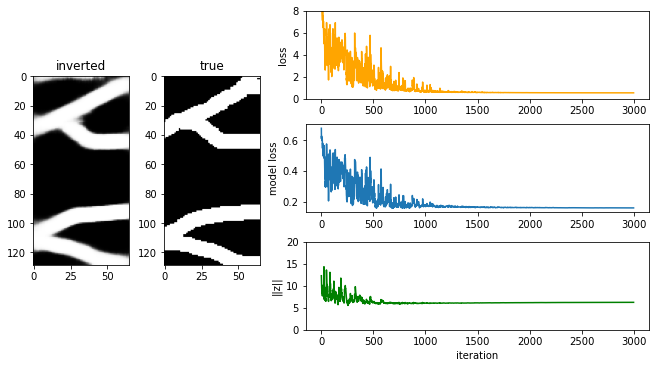

In [12]:
# Extract values in minimum for each initial model:
dRMSEs_min = []
zs_min = []
for i in range(len(dRMSEs)):
    it_min = np.argmin(dRMSEs[i])
    dRMSEs_min.append(dRMSEs[i][it_min])
    zs_min.append(zs[i][it_min])

# Number of accepted models:
updict = {'mc1':0.606,'mc2':0.998,'mc3':1.096,'mv1':0.524,'mv2':0.958,'mv3':0.734}
uplim = updict[suffix]
acmods = np.sum(np.array(dRMSEs_min)<=uplim)
print('accepted model ring clip: {0}'.format(acmods))

# Plot dRMSE vs iterations for one model.
mi = 0
datcost = dRMSEs[mi]
modelcost = mRMSEs[mi]
it_min = np.argmin(datcost)
print('lr = {0}'.format(SGDpars.lr))
print('min for iteration #: {0}'.format(it_min))
print('min data RMSE: {0}'.format(dRMSEs_min[mi]))
print('z norm at min: {0}'.format(np.linalg.norm(zs_min[mi])))
with np.printoptions(precision=3, suppress=True):
    print('z at min:{0}'.format(zs_min[mi]))

# Get znorms vs. iterations
znorms = np.zeros(len(zs[0]))
for i in range(len(znorms)):
    znorms[i] = np.linalg.norm(zs[mi][i][:][0])

# joint subplot
fig = plt.figure(figsize=(9,5), constrained_layout=True)
grid = fig.add_gridspec(3,4)

# first
ax = fig.add_subplot(grid[:,0])
ax.imshow(models_costmin[mi], cmap='Greys_r')
ax.set_title('inverted')

# second
ax = fig.add_subplot(grid[:,1])
ax.imshow(model_true[0,0,:,:], cmap='Greys_r')
ax.set_title('true')

# third
ax = fig.add_subplot(grid[0,2:])
ax.plot(datcost, c='orange')
ax.set_ylim((0.0,8.0))
ax.set_ylabel('loss')

# fourth
ax = fig.add_subplot(grid[1,2:])
ax.plot(modelcost)
#ax.set_ylim((0.0,1.0))
ax.set_ylabel('model loss')

# fifth
ax = fig.add_subplot(grid[2,2:])
ax.plot(znorms,c='g')
ax.set_ylim((0.0,20.0))
ax.set_ylabel('||z||')
ax.set_xlabel('iteration')

### Plot inversion results for all initial models:

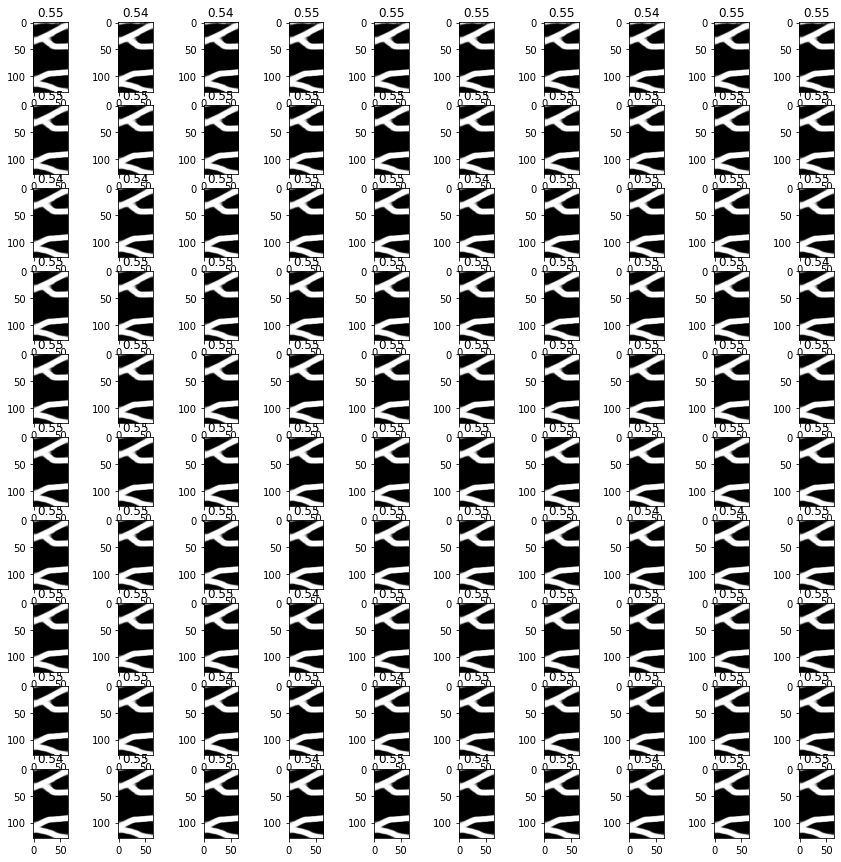

In [13]:
# plot all inverted models
plot_invmodels(models_costmin,dRMSEs_min)

100
mean of ||z|| for accepted: 6.242631560350468
mean of dRMSE for accepted: 0.546393632888794
mean of ||z|| for rejected: nan
mean of dRMSE for rejected: nan
mean of ||z|| for all: 6.242631560350468
mean of dRMSE for all: 0.546393632888794


/home/jorge/anaconda3/envs/pg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jorge/anaconda3/envs/pg/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jorge/anaconda3/envs/pg/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


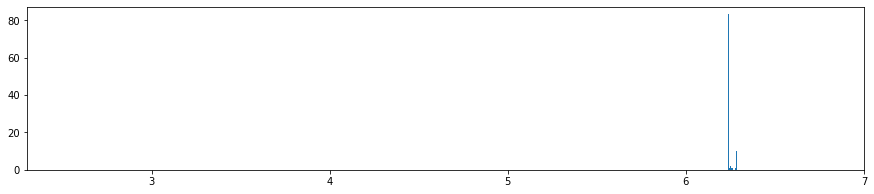

In [14]:
# Get accepted z_mins and plot histogram of norms of these accepted z_mins
derror = np.array(dRMSEs_min)
zs_minmat = ztomat(zs_min)
z_acc = zs_minmat[derror<=uplim]
z_rej = zs_minmat[derror>uplim]
derror_acc = derror[derror<=uplim]
derror_rej = derror[derror>uplim]
znorms_acc = np.linalg.norm(z_acc,axis=1)
znorms_rej = np.linalg.norm(z_rej,axis=1)
znorms_all = np.linalg.norm(zs_minmat,axis=1)
fig,ax = plt.subplots(figsize=(15,3))
ax.hist(znorms_acc)
ax.set_xlim(2.3,7.0)
#ax.hist(znorms_rej)
#b=plt.hist(znorms_rej)
print(len(derror_acc))
print('mean of ||z|| for accepted: {0}'.format(np.mean(znorms_acc)))
print('mean of dRMSE for accepted: {0}'.format(np.mean(derror_acc)))
print('mean of ||z|| for rejected: {0}'.format(np.mean(znorms_rej)))
print('mean of dRMSE for rejected: {0}'.format(np.mean(derror_rej)))
print('mean of ||z|| for all: {0}'.format(np.mean(znorms_all)))
print('mean of dRMSE for all: {0}'.format(np.mean(derror)))

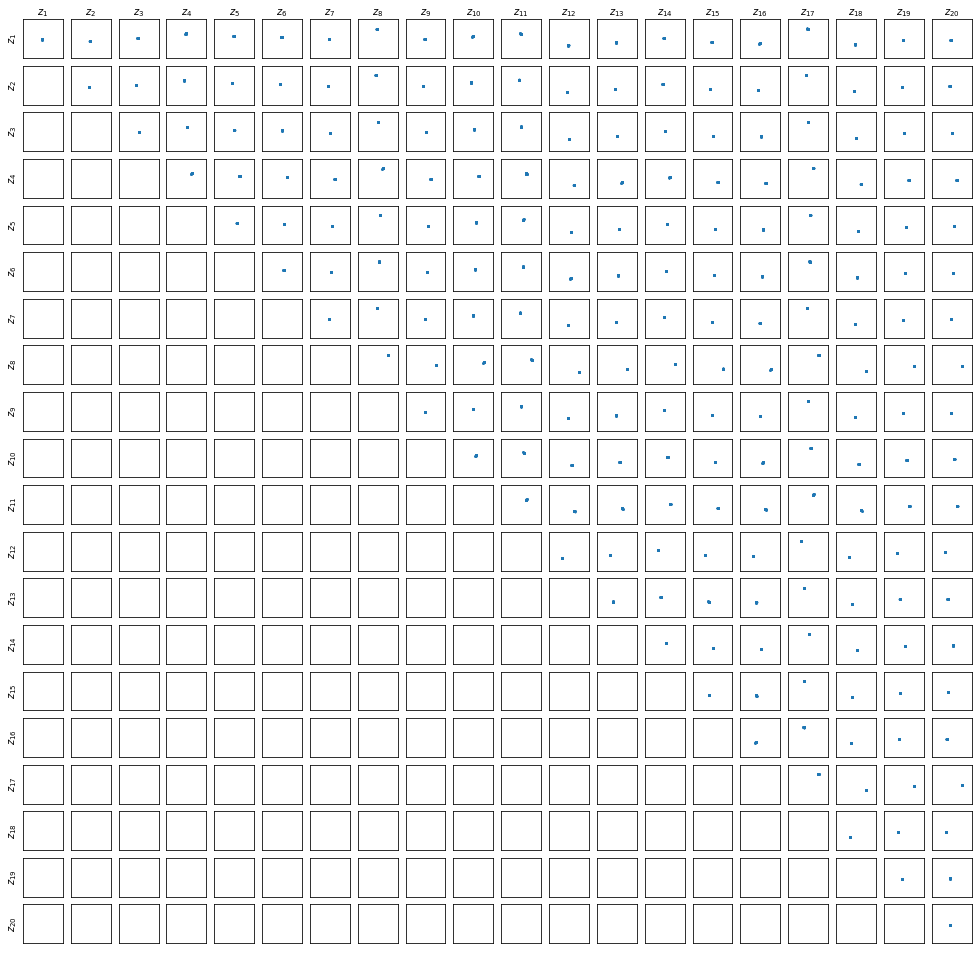

In [15]:
nz = SGDpars.zinit[0].size
plot_zs(nz,z_acc)

### Save inversion results (required for plots in the manuscript):

In [16]:
# create directory first time or only use as target for save when it already exists:
sdir = 'Results_linear{0}'.format(noisestr)
if sdir not in os.listdir():
    os.mkdir(sdir)

In [17]:
# save all
# string for SGD parameters:
if SGDpars.clr<1.0:
    sreg = 'd' # decreasing learning rate
else:
    sreg = 'n'

if SGDpars.batch_size == 625:
    bat = 'n' # no data batching
else:
    bat = 'b'

ky = DGM[0]+SGDpars.optimizer[0]+bat+SGDpars.reg[0]+sreg

# save as numpy arrays
np.save(Path('{2}/dRMSEs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(dRMSEs))
np.save(Path('{2}/mRMSEs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(mRMSEs))
np.save(Path('{2}/modsmin_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(models_costmin))
np.save(Path('{2}/zs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(zs))

print('saved for {0}, case: {1}, in dir: {2}'.format(suffix,ky,sdir))

saved for mc2, case: VSbrd, in dir: VAE_SGD_linear
